In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesRegressor
from IPython.display import display
from sklearn import metrics

In [3]:
PATH = '../data/bulldozers/'
PATH

'../data/bulldozers/'

In [4]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory = False,
                    parse_dates = ["saledate"])

In [5]:
df_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_raw.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [7]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [8]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

In [9]:
add_datepart(df_raw,'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

In [10]:
df_raw.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',


In [11]:
train_cats(df_raw)

In [12]:
df_raw.UsageBand.cat.categories # UsageBand is a column here.

Index(['High', 'Low', 'Medium'], dtype='object')

In [13]:
df_raw.UsageBand.cat.set_categories(['High','Medium', 'Low'], inplace = True, ordered = True)

Normally, pandas will continue displaying the text categories, while treating them as numerical data internally. Optionally, we can replace the text categories with numbers, which will make this variable non-categorical, like so:.

In [14]:
df_raw.UsageBand = df_raw.UsageBand.cat.codes
df_raw.UsageBand

0         2
1         2
2         0
3         0
4         1
         ..
401120   -1
401121   -1
401122   -1
401123   -1
401124   -1
Name: UsageBand, Length: 401125, dtype: int8

In [15]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

In [16]:
# saving/creating checkpoint. it saves it to disk: to_feather() function
os.makedirs('tmp', exist_ok = True)
df_raw.to_feather('../tmp/bulldozers-raw')

In [17]:
df_raw = pd.read_feather('../tmp/bulldozers-raw') # loading saved df

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable. All of this is done by the proc_df function



In [18]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [19]:
nas

{'auctioneerID': 2.0, 'MachineHoursCurrentMeter': 0.0}

In [20]:
y[:5]

array([11.09741, 10.95081,  9.21034, 10.55841,  9.30565])

In [21]:
df.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,999089,3157,121,3.0,2004,68.0,2,950,296,...,320,False,False,False,False,False,False,1163635200,False,False
1,1139248,117657,77,121,3.0,1996,4640.0,2,1725,527,...,86,False,False,False,False,False,False,1080259200,False,False
2,1139249,434808,7009,121,3.0,2001,2838.0,0,331,110,...,57,False,False,False,False,False,False,1077753600,False,False
3,1139251,1026470,332,121,3.0,2001,3486.0,0,3674,1375,...,139,False,False,False,False,False,False,1305763200,False,False
4,1139253,1057373,17311,121,3.0,2007,722.0,1,4208,1529,...,204,False,False,False,False,False,False,1248307200,False,False


In [22]:
model = RandomForestRegressor(n_jobs = -1)
model.fit(df, y)
model.score(df, y)

C:\ProgramData\Anaconda3\envs\fastai-cpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9830853963008698

to check if our data is overfitting we need a validation set

In [23]:
def split_vals(a, n):return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape, n_trn

((389125, 66), (389125,), (12000, 66), 389125)

## BASE MODEL
lets try our model again, this time with seperate training and validation sets.

In [24]:
#m = model
def rmse(x, y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
          m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res, """1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared valid""")

In [25]:
m = RandomForestRegressor(n_jobs = -1)
%time m.fit(X_train, y_train)
print_score(m)

C:\ProgramData\Anaconda3\envs\fastai-cpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Wall time: 17 s
[0.09041501421112516, 0.2484959844295198, 0.9829149625193077, 0.8897225476807653] 1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared valid


## Speeding things up

In [26]:
df_train, y_train, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_train, 20000)
y_train, _ = split_vals(y_train, 20000)
X_train.shape

(20000, 66)

In [27]:
m = RandomForestRegressor(n_jobs = -1)
m.fit(X_train, y_train)
print_score(m)

C:\ProgramData\Anaconda3\envs\fastai-cpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.11002160629513381, 0.3680022363516171, 0.9736690497463696, 0.7581484418186298] 1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared valid


## Single tree

In [28]:
m =  RandomForestRegressor(n_estimators = 1, max_depth = 4, bootstrap = False, n_jobs = -1)
m.fit(X_train, y_train)
print_score(m)
# n_estimators: no of trees
# we wanna make a small tree hence max_depth is kept 3
# bootstrap: A randomforest randomizes a bunch of things and to turn that off we use bootstrap
# = False

[0.4827682117438165, 0.516779097393255, 0.49302341481268885, 0.5230664740976425] 1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared valid


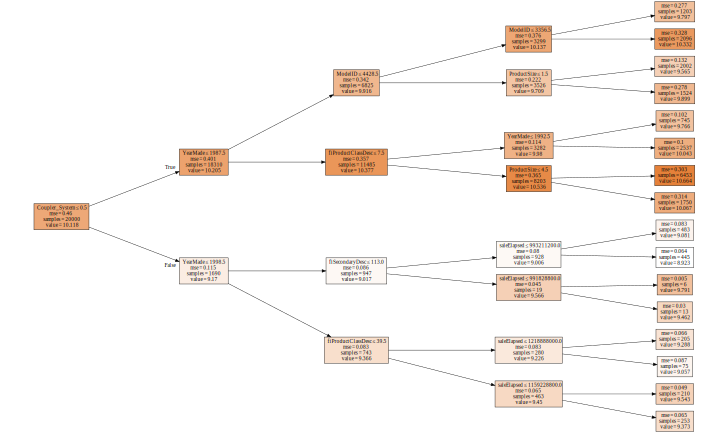

In [29]:
draw_tree(m.estimators_[0], df_train, precision = 3)

In [30]:
m.estimators_[0]

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1978008469, splitter='best')

In [31]:
m =  RandomForestRegressor(n_estimators = 1, bootstrap = False, n_jobs = -1)
m.fit(X_train, y_train)
print_score(m)

[5.329070518200751e-17, 0.4741262392823599, 1.0, 0.5985458463105053] 1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared valid


## Bagging

To learn about bagging in random forests, let's start with our basic model again.

In [32]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

C:\ProgramData\Anaconda3\envs\fastai-cpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.11102818767515303, 0.35560281295247137, 0.9731850450486188, 0.7741717081965861] 1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared valid


We'll grab the predictions for each individual tree, and look at one example.

In [33]:
m.estimators_
# After building a randomforest, each tree is stored in the attribute
# estimators_

[DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=975663939, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=550200775, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=556436061, splitter='best'),
 DecisionTreeRegressor

In [34]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds.shape


(10, 12000)

In [35]:
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([8.9872 , 9.3501 , 9.10498, 9.04782, 9.04782, 8.92266, 8.92266, 9.10498, 9.04782, 9.51044]),
 9.104648473856058,
 9.104979856318357)

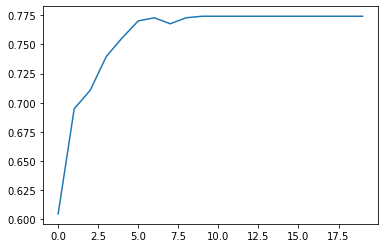

In [36]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis = 0)) for i in range(20)])
# plotting r^2(on y) against mean of all predictions(which is given) upto the ith tree

The shape of this curve suggests that adding more trees isn't going to help us much. Let's check. (Compare this to our original model on a sample)

In [37]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.10114618810637106, 0.35564574904019336, 0.9777459217718291, 0.7741171711211716] 1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared valid


In [38]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.0951925444755216, 0.35610922114464694, 0.9802886467457795, 0.7735280534061351] 1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared valid


In [39]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.0921832241022764, 0.3503170359300123, 0.9815152169838389, 0.7808353586252633] 1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared valid


In [40]:
m = RandomForestRegressor(n_estimators=100, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09193161208099436, 0.3532042358818251, 0.9816159868640866, 0.7772079033276987] 1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared valid


## Out of Bag(OOB) score

Is our validation set worse than our training set because we're overfitting, or beacuse the valid_ds is for a different time period, or a bit of both?
With the existing information we've shown, we can't tell. However, random forests have a very clear trick called Out-Of--Bag score(OOB) whih can handle this(and more)!

The idea is to calculate error on the training set, but only include the trees in the calculation of the row's error where that row was not included in the training that tree. This allows us to see whether the model is over-fitting, without needing a seperate valid_ds.

This also has the benefit of allowing us to see whether our model generalies, even if we only have a small amount of data so want to avoid seperating some out to create a validation set.

This is as simple as addin one more parameter to our model constructor. We print the OOb error last out in our print_score function below.




In [41]:
m = RandomForestRegressor(n_estimators=40, oob_score=True, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.0952661105133972, 0.3556206611723577, 0.9802581685924575, 0.7741490383300187, 0.859990831290807] 1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared valid


This shows that our validation set time difference is making an impact as is model over-fitting.

# Reducing overfitting

# Subsampling

It turns out that one of the easiest ways to avoid overfitting is also one of the best ways to speed up analysis:subsampling.
Let's return to using our full dataset, so that we can demonstrate the impact of this technique.
    

In [42]:
len(df_raw)

401125

In [43]:
n_trn

389125

In [44]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
X_train.shape, X_valid.shape


((389125, 66), (12000, 66))

The basic idea is this: rather than limit the total amount of data that our model can access, let's instead limit them to a different random subset per tree. That way, given enough trees, the model can still see all the data, but for each individual tree it'll be just as fast as if we had cut down our dataset as before.

In [45]:
?set_rf_samples

In [46]:
set_rf_samples(20000)

In [47]:
m = RandomForestRegressor(n_jobs = -1, oob_score = True)
%time m.fit(X_train, y_train)
print_score(m)

C:\ProgramData\Anaconda3\envs\fastai-cpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Wall time: 4.27 s
[0.24113814869098663, 0.27440375670841094, 0.8784747086966006, 0.8655291718560536, 0.8658451311019537] 1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared valid


In the video, why is the oob_score = True when we take a subsample?
As the notes above is shown, they’re not compatible with each other.

ANSWER:
I think it is ‘generally’ not recommended but it can be kept true, depending on subsampling. So it depends on the ratio of total n_rows of complete data and number of subsamples set using set_rf_subsample. For e.g. if n_rows of data = 100, and set subsample = 80, then you can go with oob_score = True as it will calculate validation score for remaining 20 for each tree using model constructed using 80 observations.

But practically this is rarely going to be the case. Because of large size of data, you will have n_rows = 1 million (for e.g) and subsample setting = 100,000 (i.e each tree will only use 100,000 random selected rows to make rf model). So, then it doesn’t make sense to validate score on remaining 900,000 (1M- 100k) based on model made using only 100,000 observations.

And you would use ‘set_rf_subsample’ mostly in those cases where you have large amount of data and you want to speed up hyperparameter tuning.

Now, since each additional tree allows the model to see more data, this approach can make additional trees more useful.

In [48]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 12.3 s
[0.22669627210806143, 0.2632851914787798, 0.8925952266438141, 0.8762056454988154, 0.8811402281657962] 1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared valid


## Tree building parameters

We revert to using a full bootstrap sample in order to show the impact of other over-fitting avoidance methods.

In [49]:
reset_rf_samples()

Let's get a baseline for this full set to compare to:

In [50]:
def dectree_max_depth(tree):
    children_left = tree.children_left
    children_right = tree.children_right

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

In [51]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.0783012826503975, 0.23736456833903888, 0.9871863582195114, 0.8993810553908579, 0.9086458330794439] 1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared valid


In [52]:
t = m.estimators_[0].tree_

In [53]:
dectree_max_depth(t)

47

In [54]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)
# min_samples_leaf:can be 3,5,10,25

[0.1405919178686644, 0.2345517792339669, 0.9586899674869879, 0.9017516111067593, 0.9070600448542279] 1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared valid


In [55]:
t=m.estimators_[0].tree_

In [56]:
dectree_max_depth(t)

36

Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with `min_samples_leaf`) that we require some minimum number of rows in every leaf node. This has two benefits:

- There are less decision rules for each leaf node; simpler models should generalize better
- The predictions are made by averaging more rows in the leaf node, resulting in less volatility
- values can be  1, 3, 5, 10, 25, 100

In [57]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11491382808668657, 0.2331812617030028, 0.9724018855790252, 0.9028964137380979, 0.9086277484209101] 1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared valid


We can also increase the amount of variation amongst the trees by not only use a sample of rows for each tree, but to also using a sample of *columns* for each *split*. We do this by specifying `max_features`, which is the proportion of features to randomly select from at each split.
- None
- 0.5
- 'sqrt'

In [58]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11891820328590734, 0.22744926435178198, 0.9704449632370726, 0.9076116848731633, 0.9118372360313208] 1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared valid


We can't compare our results directly with the Kaggle competition, since it used a different validation set (and we can no longer to submit to this competition) - but we can at least see that we're getting similar results to the winners based on the dataset we have.

The sklearn docs [show an example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) of different `max_features` methods with increasing numbers of trees - as you see, using a subset of features on each split requires using more trees, but results in better models:
![sklearn max_features chart](http://scikit-learn.org/stable/_images/sphx_glr_plot_ensemble_oob_001.png)

In [59]:
m = ExtraTreesRegressor(n_jobs= -1, oob_score = True, bootstrap = True)
m.fit(X_train, y_train)
print_score(m)

C:\ProgramData\Anaconda3\envs\fastai-cpu\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\envs\fastai-cpu\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[0.09245258969095521, 0.2584400363361865, 0.982136235387729, 0.8807200191156204, -1.32456827480688] 1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared valid


would you look at that R**2 for valid_ds. BIG OOF!

In [60]:
m = ExtraTreesRegressor(n_jobs= -1, oob_score = True, bootstrap = True, n_estimators=40, min_samples_leaf=3, max_features=0.5)
m.fit(X_train, y_train)
print_score(m)

[0.1538708239045166, 0.2597924352433148, 0.9505179840942618, 0.8794683849577631, 0.8994473552020028] 1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared valid


NOT BAD extratreesregressor!  
(end of lesson2)

## Random Forest Model Interpretation

In [61]:
PATH = "data/bulldozers/"

df_raw = pd.read_feather('../tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [62]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,0,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,0,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,1,S175,...,23,3,204,False,False,False,False,False,False,1248307200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6333336,9.259131,1840702,21439,149,1.0,2005,NaN,-1,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401121,6333337,9.305651,1830472,21439,149,1.0,2005,NaN,-1,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401122,6333338,9.350102,1887659,21439,149,1.0,2005,NaN,-1,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401123,6333341,9.104980,1903570,21435,149,2.0,2005,NaN,-1,30NX,...,25,1,298,False,False,False,False,False,False,1319500800


In [63]:
def rmse(x, y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
          m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res, """1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared valid""")

## Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [64]:
set_rf_samples(50000)

In [65]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20565525848233795, 0.2480852035240476, 0.911607694134976, 0.8900868387168829, 0.8945865975842355] 1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared valid


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [66]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

Wall time: 1.44 s


(9.254490670594745, 0.2477682083829608)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [67]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

Exception in thread Thread-987:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\fastai-cpu\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\envs\fastai-cpu\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "C:\ProgramData\Anaconda3\envs\fastai-cpu\lib\concurrent\futures\process.py", line 295, in _queue_management_worker
    shutdown_worker()
  File "C:\ProgramData\Anaconda3\envs\fastai-cpu\lib\concurrent\futures\process.py", line 253, in shutdown_worker
    call_queue.put_nowait(None)
  File "C:\ProgramData\Anaconda3\envs\fastai-cpu\lib\multiprocessing\queues.py", line 129, in put_nowait
    return self.put(obj, False)
  File "C:\ProgramData\Anaconda3\envs\fastai-cpu\lib\multiprocessing\queues.py", line 83, in put
    raise Full
queue.Full



BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

(9.254490670594745, 0.2477682083829608)

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

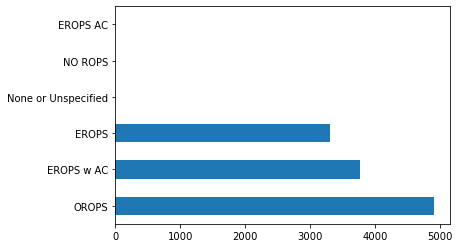

In [68]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh()
# barh() stands for make a horizontal bar plot

In [69]:
fields = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[fields].groupby('Enclosure', as_index=False).mean()
enc_summ
# we took the avg of these 3 fields and displayed them against their enclosure values.

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.837738,0.271957
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.575302,0.264762
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.682172,0.219680


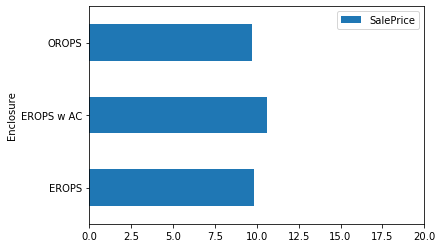

In [70]:
# removing the null ones
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,20))
# x_lim is simply the max value of x intercept to show in graph.

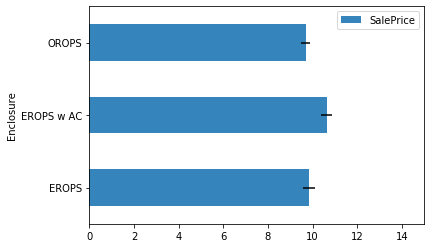

In [71]:
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xerr='pred_std', alpha=0.9, xlim=(0,15))
# alpha parameter is simply contrast of plot(?)
# xerr and yerr are the error bars denoted by that black line. they show the variance of set.

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

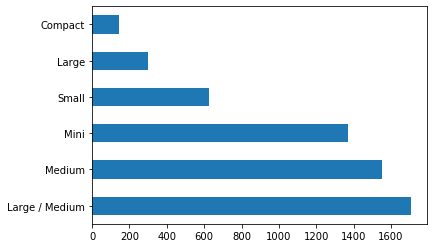

In [72]:
raw_valid.ProductSize.value_counts().plot.barh()

In [73]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.811882,0.330681
Large,10.470589,10.396441,0.355127
Large / Medium,10.691871,10.647963,0.297737
Medium,10.681511,10.622628,0.285238
Mini,9.535147,9.559201,0.242333
Small,10.324448,10.323379,0.310952


In [74]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Large             0.034158
Compact           0.033702
Small             0.030121
Large / Medium    0.027962
Medium            0.026852
Mini              0.025351
dtype: float64

This tells us that for ProductSize compact and large, our predictions are less accurate. So if you go back to the bar plot of ProductSize you can see the reason why. Its because we have lesser examples for those two groups.  
You can use this confidence interval for 2 main purposes:
- You can look at the avg confidence interval by group to find out which groups are you least confident about.  
- Perhaps, more importantly, you can look at them for specific rows. To check the model's confidence when predicting the y for certain values of inputs.

## Feature Importance

rf_feat_importance--> sorts in descending order of importance.

In [75]:
fi = rf_feat_importance(m, df_train)
fi[:10] # picking the top 10.

,cols,imp
5,YearMade,0.175275
37,Coupler_System,0.138189
13,ProductSize,0.102041
14,fiProductClassDesc,0.079252
2,ModelID,0.055087
63,saleElapsed,0.051325
10,fiSecondaryDesc,0.046323
8,fiModelDesc,0.036026
38,Grouser_Tracks,0.030935
19,Enclosure,0.030501


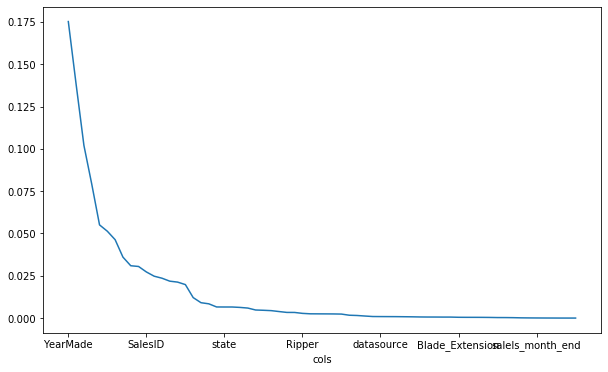

In [76]:
fi.plot('cols', 'imp', figsize=(10, 6), legend=False)

In [77]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

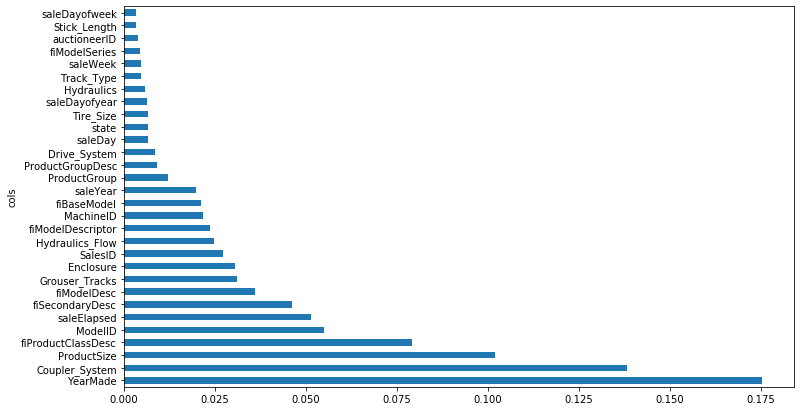

In [78]:
plot_fi(fi[:30])

In [79]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

24

In [80]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train.shape, X_valid.shape, n_trn, df_trn.shape

((389125, 66), (12000, 66), 389125, (401125, 66))

In [81]:
y_train.shape

(389125,)

In [82]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)
df_keep.shape, X_train.shape, X_valid.shape, n_trn, df_train.shape

((401125, 24), (389125, 24), (12000, 24), 389125, (30000, 66))

In [83]:
len(X_train)

389125

In [84]:
len(y_train)

389125

Removing Redundant columns helps our random forests get better( if it gets worse than the removed columns were not redundant after all) as then the trees would have less things to split on and so it'll less often be likely to find a crappy row, also makes us train it faster. Therefore Feature importance should be done.  
  
When you're removing redundant columns you may also be removing sources of colinearity( two columns that migt be related to each other). Colinearity doesn't make your rf less predictive but if you have two columns that are related to each other, then the importance will kind of split up between the two colinear columns. So by removing some of those columns, it'll make your feature imp plot more clearer. So, you trust the 2nd feature imp(down below) much better than the first one.

In [85]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20647502491436903, 0.2456103618519543, 0.9109016050718934, 0.8922688380843472, 0.8945835363909759] 1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared valid


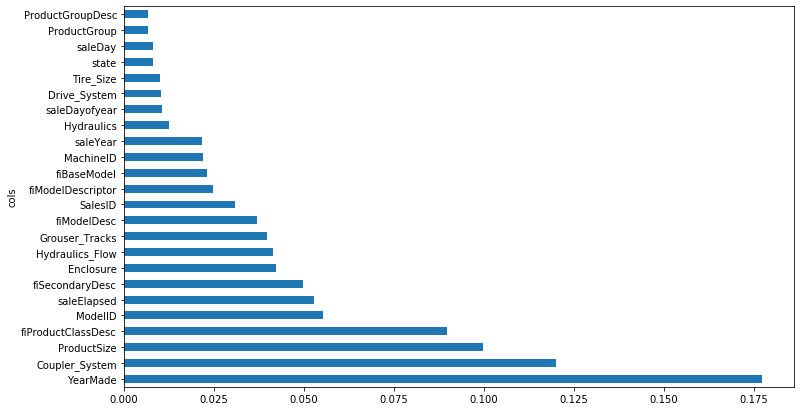

In [86]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

Key thing that has happened that you have removed redundant column, along with sources of colinearity.Colinearity between two columns leads to splitting the total importance between the two of them and thus gives a non-clear importance plot. Before YearMade was pretty close to Coupler_System. But there must have been a bunch of things that were colinear with YearMade and now we can see that YearMade really matters. This feature imp plot is more reliable than the one before because it has less colinearity to confuse us.  
(end of lesson3)

## One hot Encoding

proc_df's optional *max_n_cat* argument will turn some categorical variables into new columns.

For example, the column **ProductSize** which has 6 categories:

* Large
* Large / Medium
* Medium
* Compact
* Small
* Mini

gets turned into 6 new columns:

* ProductSize_Large
* ProductSize_Large / Medium
* ProductSize_Medium
* ProductSize_Compact
* ProductSize_Small
* ProductSize_Mini

and the column **ProductSize** gets removed.

It will only happen to columns whose number of categories is no bigger than the value of the *max_n_cat* argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

In [87]:
df_trn2, y_trn, nas = proc_df(df_raw, "SalePrice", max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20743165280303374, 0.2543388778547424, 0.9100740816457774, 0.8844756654159065, 0.8922955573716131] 1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared valid


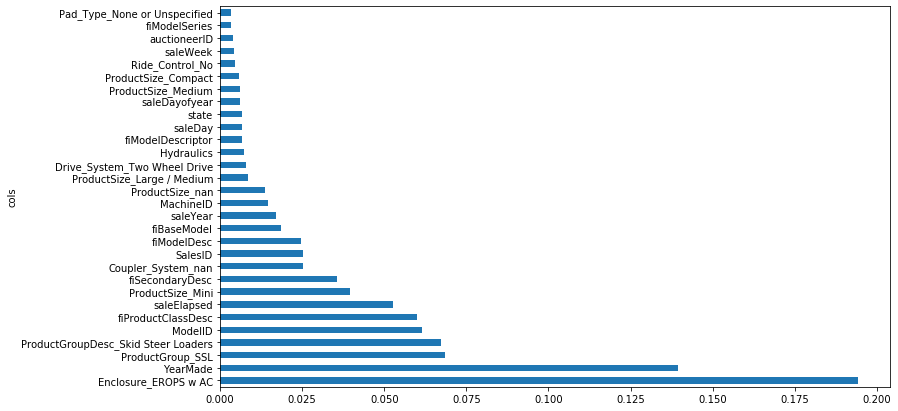

In [88]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:30])

## Removing Redundant features  
One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [89]:
from scipy.cluster import hierarchy as hc

Below steps are standard in creating a dendrogram

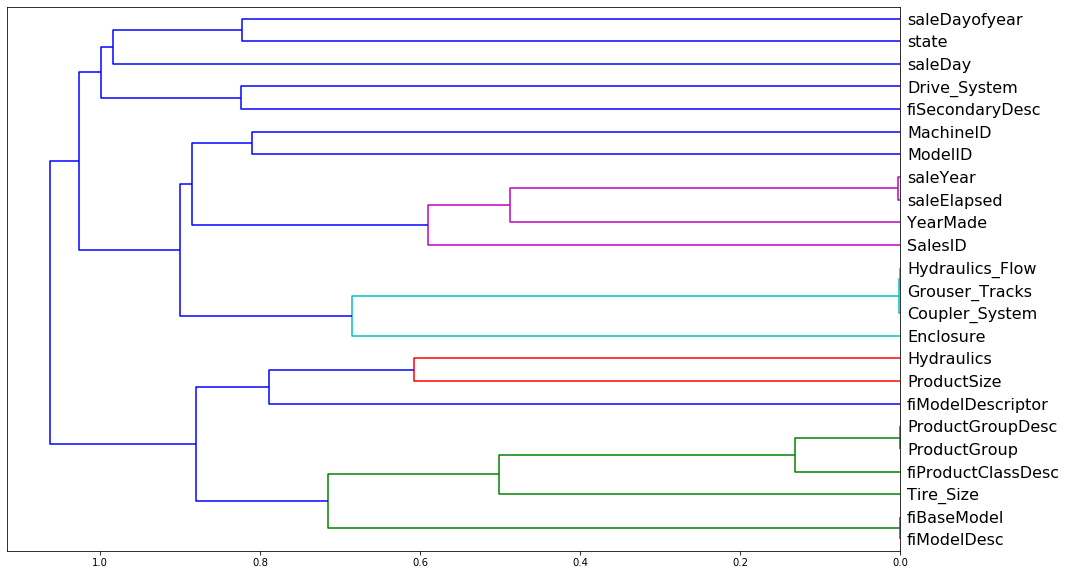

In [90]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z=hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [91]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf= 5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x,y_train)
    return m.oob_score_

Here's our baseline.

In [92]:
get_oob(df_keep)

0.8907776289076209

Now we try removing each variable one at a time.

In [93]:
for c in ('saleYear', 'saleElapsed', 'Grouser_Tracks', 'Hydraulics_Flow', 'Coupler_System', 'ProductGroup', 'ProductGroupDesc', 'fiBaseModel', 'fiModelDesc'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8903481722936373
saleElapsed 0.887969036394718
Grouser_Tracks 0.8908683180541102
Hydraulics_Flow 0.8909102585369886
Coupler_System 0.8910166493609673
ProductGroup 0.8907880044630231
ProductGroupDesc 0.8909867410260429
fiBaseModel 0.8901548491757992
fiModelDesc 0.8897758364527528


It looks like we can try one from each group for removal. Let's see what that does.

In [94]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System', 'ProductGroup']
get_oob(df_keep.drop(to_drop, axis=1))

0.8893299888117804

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [95]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [96]:
np.save('../tmp/keep_cols.npy', np.array(df_keep.columns))

In [97]:
keep_cols = np.load('../tmp/keep_cols.npy', allow_pickle=True)
df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset

In [98]:
reset_rf_samples()

In [99]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12581118299024785, 0.22611923588578509, 0.9669194045619575, 0.9086890224196567, 0.908510592728725] 1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared valid


## Partial Dependance

In [100]:
from pdpbox import pdp
from plotnine import *


In [101]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [102]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

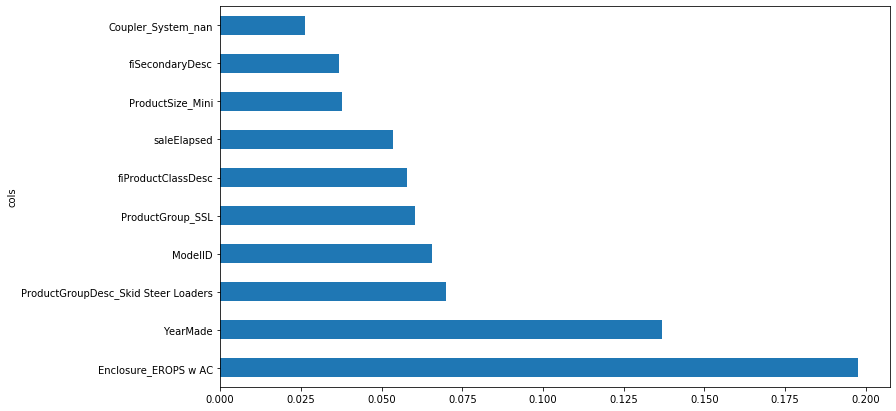

In [103]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

 YearMade is the second most important. So one obvious thing we could do would be to plot YearMade against saleElapsed because as we’ve talked about already, it seems to make sense that they are both important but it seems very likely that they are combined together to find how old was the product when it was sold. So we could try plotting YearMade against saleElapsed to see how they relate to each other.

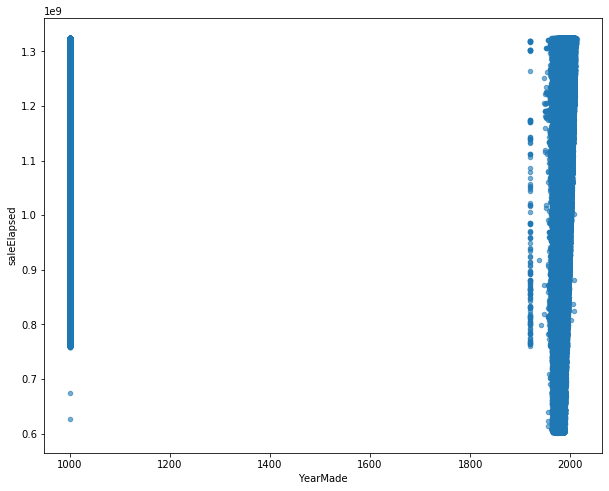

In [104]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.6, figsize=(10,8))

And when we do, we get this very ugly graph [1:09:08]. It shows us that YearMade actually has a whole bunch that are a thousand. Clearly, this is where I would tend to go back to the client and say okay, I’m guessing that these bulldozers weren’t actually made in the year 1000 and they would presumably say to me “oh yes, they are ones where we don’t know where it was made”. Maybe “before 1986, we didn’t track that” or maybe “the things that are sold in Illinois, we don’t have that data provided”, etc — they will tell us some reason. So in order to understand this plot better, I’m just going to remove them from this interpretation section of the analysis. We will just grab things where YearMade is greater than 1930.

get_sample-> gets a random sample of rows without replacement.

In [105]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)
x_all.shape

(500, 65)

In [106]:
x_all[:5]

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
893,1142201,10.736397,764151,1453,121,3.0,2004,3680.0,1,928GZ,...,16,2,259,False,False,False,False,False,False,1253059200
927,1142322,10.596635,1010028,5892,121,3.0,1997,11556.0,1,L90C,...,1,3,152,False,True,False,False,False,False,1149120000
2647,1148081,9.852194,1023799,9370,121,3.0,1997,8199.0,1,2650,...,26,3,146,False,False,False,False,False,False,1306368000
3566,1151206,9.769956,1002198,4701,121,3.0,1997,10472.0,1,544H,...,20,3,232,False,False,False,False,False,False,1250726400
4000,1152646,11.350407,1009022,3824,121,3.0,2000,10568.0,0,950G,...,10,3,222,False,False,False,False,False,False,1155168000


In [107]:
# !pip install scikit-misc

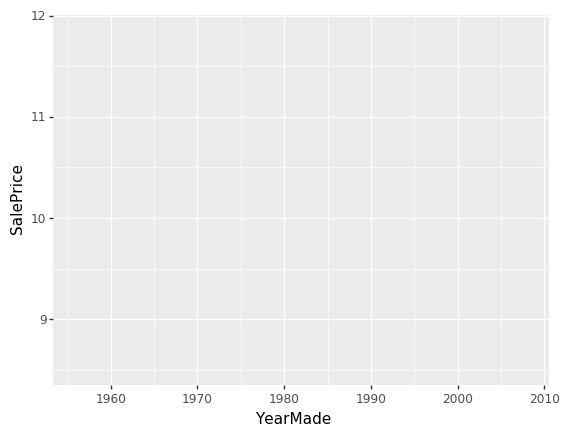

<ggplot: (-9223371929463089576)>

In [108]:
ggplot(x_all, # defining what data to use
       aes('YearMade', 'SalePrice')) # defining what the variables are

You get a different plot everytime because x_all is 500 samples of df_raw that are randomly selected

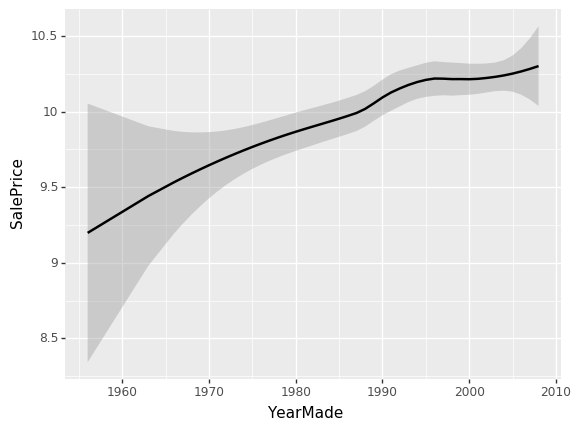

<ggplot: (-9223371929471541104)>

In [109]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')
# + in ggplot means to add chart elements
# the smoother basically creates a little linear regression for every little subset 
# of the graph and so it kind of joins it up and allows you to see a nice smooth curve
# loess stands for locally weighted regression

In [110]:
x = get_sample(X_train[X_train.YearMade>1930], 500)


In [111]:
def plot_pdp(feat, clusters = None, feat_name=None):
    feat_name= feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                       cluster=clusters is not None,
                       n_cluster_centers=clusters)

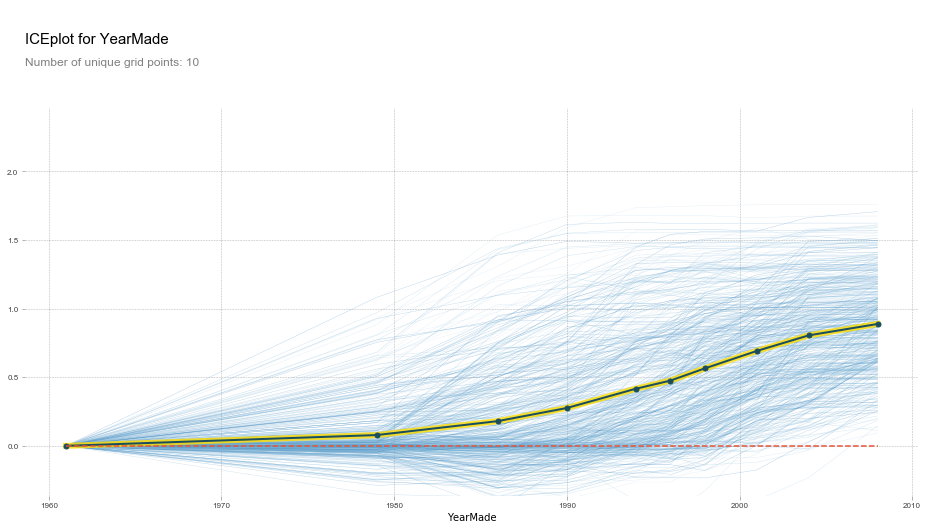

In [112]:
plot_pdp('YearMade')

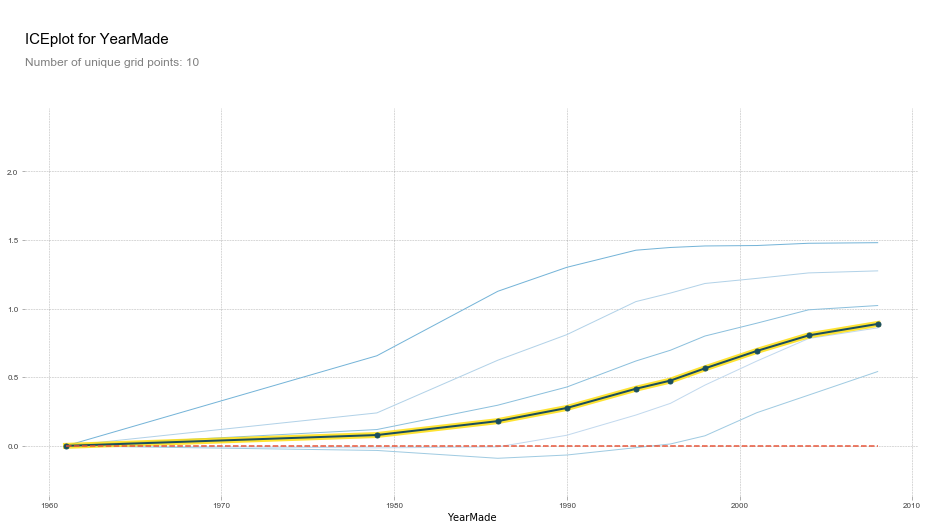

In [113]:
plot_pdp('YearMade', clusters=5)

TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

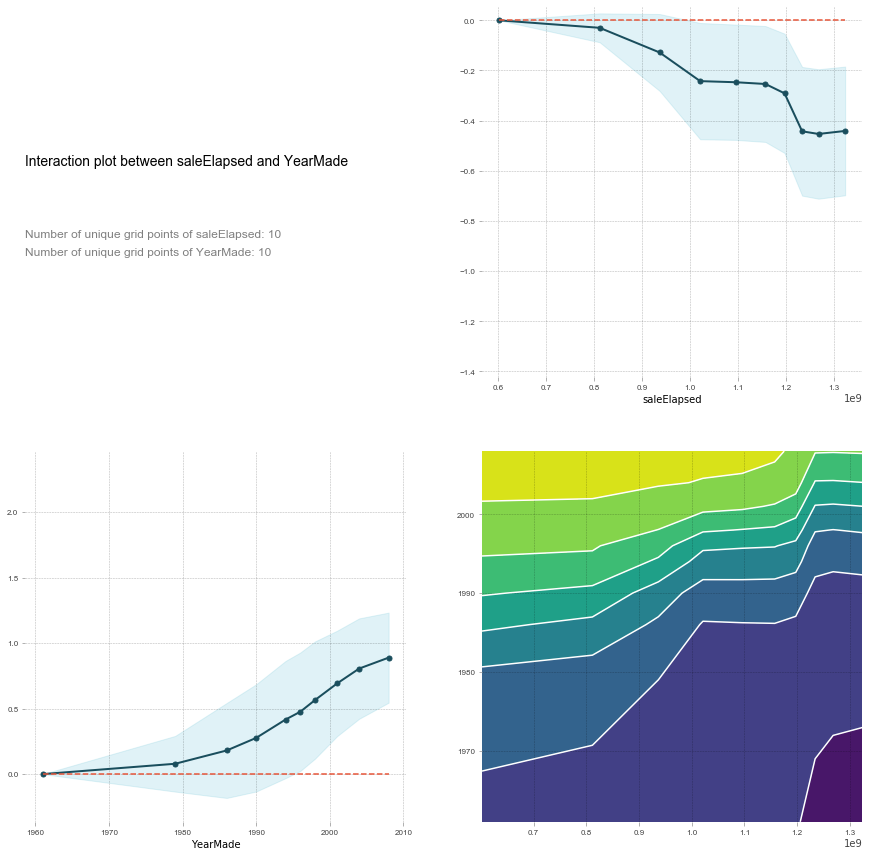

In [114]:
# Pdp interaction plot
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

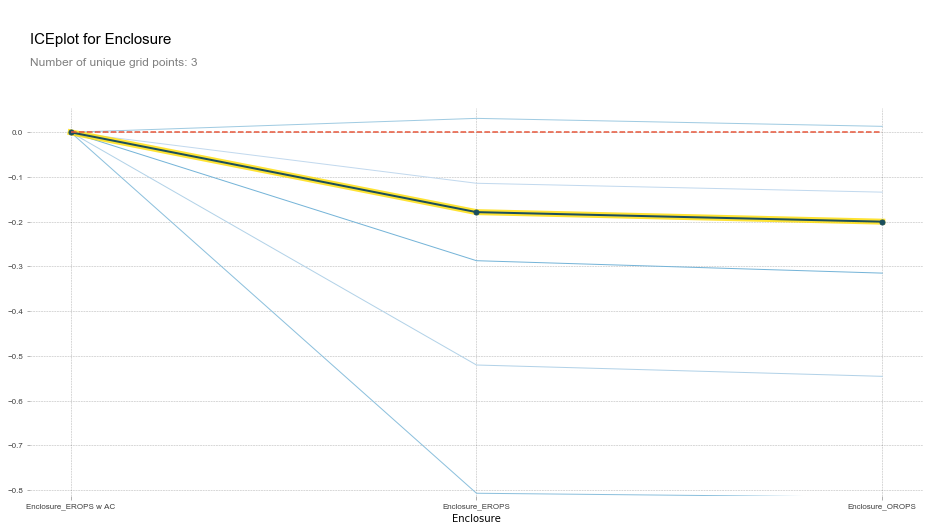

In [115]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [116]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

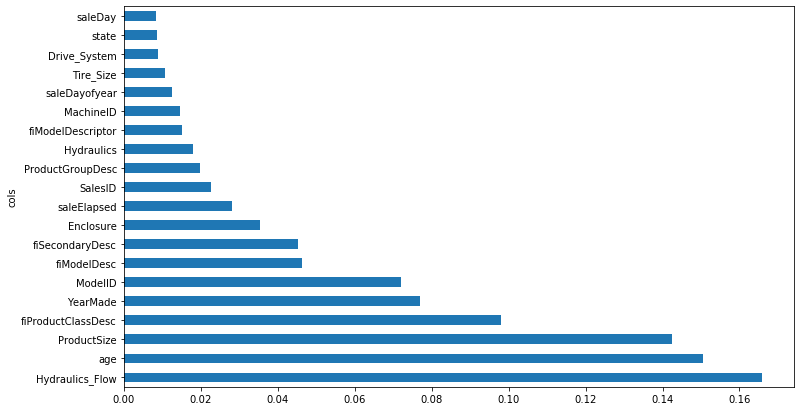

In [117]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

In [118]:
print_score(m)

[0.20692272979296422, 0.2474270292134597, 0.9105147976785695, 0.8906692681065882] 1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared valid


# Tree interpreter

In [120]:
from treeinterpreter import treeinterpreter as ti

In [121]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [130]:
X_valid.shape

(12000, 20)

In [133]:
row = X_valid.values[None, 0]
row

array([[      1999,          5,         17,        665, 1284595200,          0,       3232,          1,
           4364751,          0,          0,    2300944,          4,          0,         16,         35,
                 0,        259,         12,         11]], dtype=int64)

All columns in row 0

In [123]:
prediction, bias, contributions = ti.predict(m, row)
# predictions-> the prediction from random forest
# bias-> the avg sale across the whole original dataset. It is just
# the average BEFORE we start doing any splits
# contributions-> A column and value to split by(ie the predcitor), 
# and how much it changed the predicted value

In [136]:
prediction.shape, bias.shape, contributions.shape
# we have 20 features and so no of columns of contributions is 20.

((1, 1), (1,), (1, 20))

In [134]:
prediction

array([[9.30294]])

In [124]:
prediction[0], bias[0]

(array([9.30294]), 10.10604774314695)

In [125]:
idxs = np.argsort(contributions[0])

In [126]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.5746384934900999),
 ('age', 11, -0.12061899133465621),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.06483686745506319),
 ('fiModelDesc', 'KX1212', -0.058345016307091324),
 ('fiSecondaryDesc', nan, -0.05758250053154366),
 ('SalesID', 4364751, -0.055353288506493084),
 ('Enclosure', 'EROPS', -0.04698939095984023),
 ('saleDayofyear', 259, -0.025688620037641118),
 ('MachineID', 2300944, -0.0131909849483824),
 ('fiModelDescriptor', nan, -0.01078361295515271),
 ('Tire_Size', nan, -0.0038067980953178536),
 ('saleElapsed', 1284595200, -0.0031929204967534376),
 ('saleDay', 16, -0.0027332379527846397),
 ('state', 'Ohio', 0.0002556619677410943),
 ('Drive_System', nan, 0.0016301118224526956),
 ('Hydraulics', 'Standard', 0.009458600204406763),
 ('ProductGroupDesc', 'Track Excavators', 0.01467737995376166),
 ('ModelID', 665, 0.050395469438519844),
 ('Hydraulics_Flow', nan, 0.07771743473031716),
 ('YearMade', 1999, 0.0805140735410500

In [127]:
contributions[0].sum()

-0.8031119914125705

So, if we sum up all the contributions together, and then add them to the bias, then that would give us the final prediction.
MINDBLOWN!
so if anyone tells you that you can't interpret ml models because they're like a black box(you, 10 days back), you could let them know that they're full of crap:)

# Extrapolation

In this case, if we look at our R^2 values for train_ds and valid_ds, we can still see a big difference.  
[0.12581118299024785, 0.22611923588578509, 0.9669194045619575, 0.9086890224196567, 0.908510592728725] 1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared valid  
(cell just above Pdp)  
  
In the real world, you could probably stop here but on kaggle even a 1e-3 point makes a difference. We know that our oob score should be a little worse than our valid_ds score because its using less trees so it makes sense to think that we can do a little better.

In [137]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [138]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9999900280461202

Turns out i don't have a random sample because my valid_ds can predicted with a 99.99% accuracy.

In [139]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
8,SalesID,0.774176
4,saleElapsed,0.144113
11,MachineID,0.069569
17,saleDayofyear,0.003470
3,ModelID,0.003083
6,fiModelDesc,0.001713
0,YearMade,0.001629
19,age,0.000926
18,Hydraulics,0.000342
9,Hydraulics_Flow,0.000269


In [140]:
feats=['SalesID', 'saleElapsed', 'MachineID']
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [141]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


Notice the disparity in the avg values for these columns in train and valid_ds.

In [142]:
x.drop(feats, axis=1, inplace=True)

In [144]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.978261140542225

After dropping those columns, i can still predict my valid_ds with a 97.8% accuracy.

In [145]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
16,age,0.233638
0,YearMade,0.187465
14,saleDayofyear,0.156275
3,ModelID,0.080910
5,fiModelDesc,0.064810
12,state,0.059997
11,saleDay,0.059426
2,fiProductClassDesc,0.036413
4,fiSecondaryDesc,0.024004
6,Enclosure,0.021775


In [146]:
set_rf_samples(50000)

In [147]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [148]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2076271662039711, 0.24818838685046377, 0.9099044835380343, 0.8899953897795994, 0.8933430526579561] 1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared valid


Compare with R^2 of valid_ds=0.889 from just above

In [149]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.20907422245658133, 0.24550412243983627, 0.9086442669613045, 0.8923620167261279, 0.8925270010521722] 1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared valid
saleElapsed
[0.21424505926501444, 0.25507039762599626, 0.9040695554884967, 0.8838101764010435, 0.8870755685963543] 1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared valid
MachineID
[0.2066587028252619, 0.24526081774931452, 0.9107430126581705, 0.8925752583519413, 0.895098736114568] 1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared valid
age
[0.20985511597228196, 0.250444337791461, 0.907960564066691, 0.8879864893930558, 0.8913021975570313] 1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared valid
YearMade
[0.20881691411657877, 0.2512078317015147, 0.9088689921992746, 0.8873024891657291, 0.8923524190903745] 1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared vali

In [150]:
reset_rf_samples()

In [151]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1386540517240632, 0.21793065212841126, 0.9598209229822278, 0.9151826672982766, 0.9091777888321207] 1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared valid


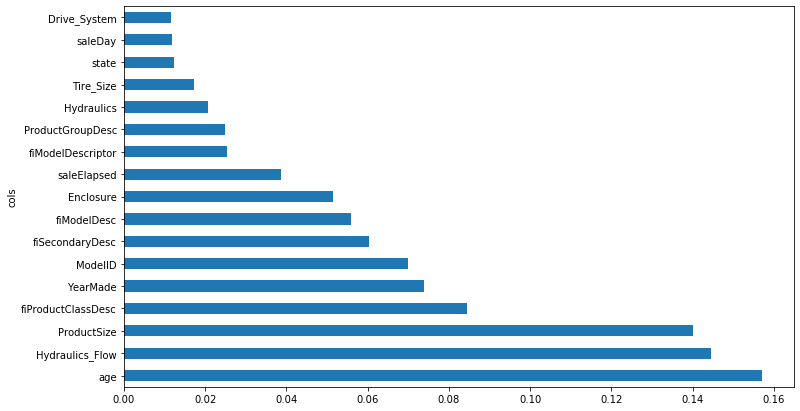

In [152]:
plot_fi(rf_feat_importance(m, X_train));

In [153]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Our final model!  
(on whole dataset)

In [154]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 47.1 s
[0.08019845975622071, 0.21143795282834538, 0.9865579074505103, 0.9201612250534521, 0.9146053294131251] 1. rmse x-y-train 2. rmse validation set 
          3.Rsquared x-y-train 4.Rsquared valid


THats  1st on the kaggle Leaderboard!